In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
events_data = pd.read_csv('..//Datasets/event_data_train.csv')
submission_data = pd.read_csv('..//Datasets/submissions_data_train.csv')
events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')
events_data['day'] = events_data.date.dt.date

submission_data['date'] = pd.to_datetime(submission_data.timestamp, unit = 's')
submission_data['day'] = submission_data.date.dt.date

users_data = events_data.groupby('user_id', as_index= False)\
        .agg({'timestamp': 'max'})\
        .rename({'timestamp':'last_timestamp'}, axis = 'columns')

now = 1526772811
drop_out_threasold = 2592000

users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threasold
users_scores = submission_data.pivot_table(index='user_id',\
                        columns = 'submission_status',\
                        values = 'step_id',\
                        aggfunc = 'count',\
                        fill_value = 0)\
                        .reset_index()
users_data = users_data.merge(users_scores, on = 'user_id', how = 'outer')
users_data = users_data.fillna(0)
users_invent_data = events_data.pivot_table(index = 'user_id',
                        columns = 'action',
                        values  = 'step_id',
                        aggfunc = 'count',
                        fill_value = 0).reset_index()

users_data = users_data.merge(users_invent_data, how = 'outer')
users_days = events_data.groupby('user_id').day.nunique()
users_days.to_frame().reset_index()
users_data = users_data.merge(users_days, on = 'user_id', how = 'outer')
users_data['passed_corse'] = users_data.passed > 170

In [3]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [4]:
# Медиана дней для тех кто прошел курс 
users_data[users_data.passed_corse].day.median()

20.0

<AxesSubplot:>

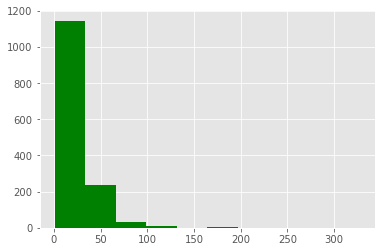

In [5]:
# Гистограмма дней 
users_data[users_data.passed_corse].day.hist(color='green', bins=10)

In [6]:
# dataframe with minimum timestamp for unique user
user_min_time = events_data.groupby('user_id', as_index=False) \
                           .agg({'timestamp':'min'}) \
                           .rename({'timestamp':'min_timestamp'}, axis=1)

In [7]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [8]:
# merge uder_min_time to users_data
users_data = users_data.merge(user_min_time, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [9]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [10]:
# Неправильный (долгий) подход
# event_data_train = pd.DataFrame()

# for user_id in users_data.user_id:
#     min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
#     time_threshold = min_user_time + 3 * 24 * 3600
    
#     user_events_data = events_data[(events_data.user_id == user_id) & 
#                                  (events_data.timestamp < time_threshold)]
    
#     event_data_train = event_data_train.append(user_events_data)
# user_events_data

In [11]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [12]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [13]:
learning_time_threshold =  3 * 24 * 3600

In [14]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp 
                               + learning_time_threshold).map(str)

In [15]:
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [16]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [17]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

In [18]:
events_data.shape

(3480703, 8)

In [19]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]

In [20]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


В процессе решения одной аналитической задачи очень часто замечаешь и другие задачи, связанные с исследуемым вопросом. В свое время, работая над предсказанием оттока студентов со stepik, я многое изменил в структуре своих курсов. 

Тогда я нашел довольно интересную закономерность прохождения онлайн курсов. Слушатели онлайн курсов очень негативно реагируют на невозможность решить задачу, иными словами, если студент застрял на определенном шаге, то он, с высокой вероятность, вообще бросит курс, чем просто пропустит этот шаг и продолжит обучение. 

Давайте найдем такой стэп, используя [данные о сабмитах](https://stepik.org/lesson/222124/step/3?unit=195045). Для каждого пользователя найдите такой шаг, который он не смог решить, и после этого не пытался решать другие шаги. Затем найдите id шага,  который стал финальной точкой практического обучения на курсе для максимального числа пользователей. 

То есть мы исследуем следующий сценарий: человек решает стэп, не может получить правильный ответ и больше не возвращается к практическим задачам. Что это за шаг такой, который отпугнул максимальное число пользователей? (__Answer__: step_id = 31978)

In [21]:
submission_data.query("submission_status == 'wrong'").value_counts('step_id').head()

step_id
31978    16084
32031    13373
32202    13002
33481    10300
32075    10003
dtype: int64

In [22]:
events_data_train.groupby('user_id').day.nunique().max()

4

In [23]:
submission_data['users_time'] = submission_data.user_id.map(str) + '_' + submission_data.timestamp.map(str)
submission_data = submission_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submission_data[submission_data.users_time <= submission_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [24]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
            .rename(columns={'day':'days'})

In [25]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
                .rename(columns={'step_id':'steps_tried'})

In [26]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [27]:
X.shape

(8913, 3)

In [28]:
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [29]:
X = X.merge(submissions_data_train.pivot_table(index='user_id',\
                        columns = 'submission_status',\
                        values = 'step_id',\
                        aggfunc = 'count',\
                        fill_value = 0)\
                        .reset_index())

In [30]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [31]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [32]:
X = X.merge(events_data_train.pivot_table(index='user_id',\
                        columns = 'action',\
                        values = 'step_id',\
                        aggfunc = 'count',\
                        fill_value = 0)\
                        .reset_index()[['user_id', 'viewed']], how='outer')

In [33]:
X = X.fillna(0)

In [34]:
X = X.merge(users_data[['user_id', 'passed_corse', 'is_gone_user']], how='outer')

In [35]:
X = X[-((X.is_gone_user == False) & (X.passed_corse == False))]

In [36]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_corse,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [37]:
X.groupby(['passed_corse', 'is_gone_user']).user_id.count()

passed_corse  is_gone_user
False         True            16560
True          False             141
              True             1284
Name: user_id, dtype: int64

In [38]:
y = X.passed_corse.map(int)
X = X.drop(['passed_corse', 'is_gone_user'], axis=1)

In [39]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [40]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


In [41]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: passed_corse, dtype: int64